In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [3]:
list(enumerate(train.columns))

[(0, 'id'),
 (1, 'vendor_id'),
 (2, 'pickup_datetime'),
 (3, 'dropoff_datetime'),
 (4, 'passenger_count'),
 (5, 'pickup_longitude'),
 (6, 'pickup_latitude'),
 (7, 'dropoff_longitude'),
 (8, 'dropoff_latitude'),
 (9, 'store_and_fwd_flag'),
 (10, 'trip_duration')]

In [4]:
list(enumerate(test.columns))

[(0, 'id'),
 (1, 'vendor_id'),
 (2, 'pickup_datetime'),
 (3, 'passenger_count'),
 (4, 'pickup_longitude'),
 (5, 'pickup_latitude'),
 (6, 'dropoff_longitude'),
 (7, 'dropoff_latitude'),
 (8, 'store_and_fwd_flag')]

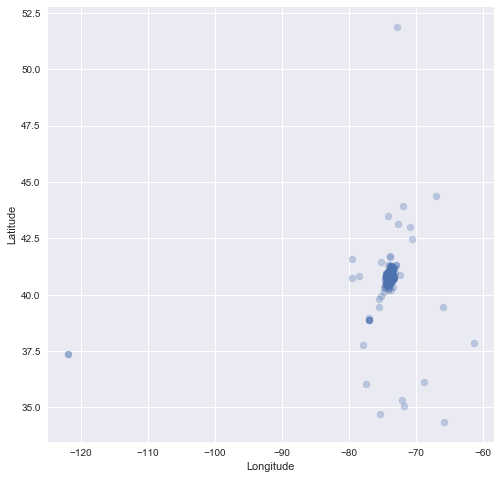

In [5]:
fig1 = plt.figure(figsize=(8, 8))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.scatter(x=train.pickup_longitude.values, y=train.pickup_latitude.values, alpha=.3)

In [6]:
fig1.savefig('./img/pickups_all.png')

In [7]:
type(train.pickup_latitude[0])

numpy.float64

(-74.099999999999994,
 -73.700000000000003,
 40.600000000000001,
 40.899999999999999)

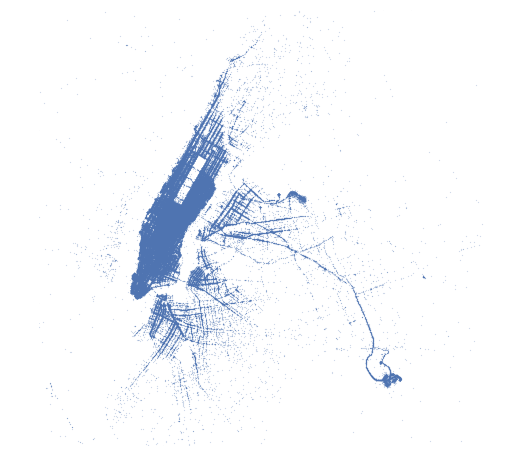

In [8]:
fig2 = plt.figure(figsize=(8, 8))
plt.scatter(x=train.pickup_longitude.values, y=train.pickup_latitude.values, s=1, alpha=.2)
plt.xlim([-74.1,-73.7])
plt.ylim([40.6, 40.9])
plt.axis('off')

#### Label pickup points by Traffic Analysis Zone

In [12]:
# Load shapefile of NY state TAZ
taz_state = gpd.read_file('./data/tl_2011_36_taz10/tl_2011_36_taz10.shp')

In [13]:
taz_state.crs

{'init': u'epsg:4269'}

In [14]:
list(enumerate(taz_state.columns))

[(0, u'ALAND10'),
 (1, u'AWATER10'),
 (2, u'COUNTYFP10'),
 (3, u'FUNCSTAT10'),
 (4, u'GEOID10'),
 (5, u'INTPTLAT10'),
 (6, u'INTPTLON10'),
 (7, u'MPOCE10'),
 (8, u'MTFCC10'),
 (9, u'STATEFP10'),
 (10, u'TADCE10'),
 (11, u'TAZCE10'),
 (12, 'geometry')]

In [15]:
type(taz_state.COUNTYFP10[0])

unicode

In [16]:
nyc_county_codes = ['005','047','061','081','085']
taz_nyc = taz_state[taz_state.COUNTYFP10.isin(nyc_county_codes)]

In [17]:
len(taz_nyc)

2243

In [18]:
taz_nyc.TADCE10.head(10)

1139    00005008
1140    00005009
1141    00005014
1142    00005009
1143    00005009
1144    00005017
1145    00005017
1146    00005017
1147    00005016
1148    00005016
Name: TADCE10, dtype: object

In [19]:
# number of Traffic Analysis Districts
len(taz_nyc.TADCE10.unique())

179

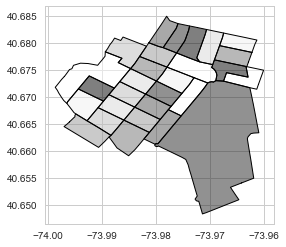

In [20]:
test_tad = taz_nyc[taz_nyc.TADCE10 == '00002014']
test_tad.plot()

In [21]:
len(test_tad)

28

In [22]:
# create identifier for county-tad pairs
# taz_nyc.groupby(['COUNTYFP10','TADCE10']).count()

#### Convert training set to a geodataframe

In [24]:
geometry = [Point(xy) for xy in zip(train.pickup_longitude, train.pickup_latitude)]
train_temp = train.drop(['pickup_longitude', 'pickup_latitude'], axis=1)
crs = {'init': 'epsg:4269'}
train_gdf = gpd.GeoDataFrame(train_temp, crs=crs, geometry=geometry)
train_gdf.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,geometry
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.964630,40.765602,N,455,POINT (-73.98215484619139 40.76793670654297)
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.999481,40.731152,N,663,POINT (-73.98041534423827 40.73856353759766)
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-74.005333,40.710087,N,2124,POINT (-73.97902679443358 40.76393890380859)
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.012268,40.706718,N,429,POINT (-74.01004028320312 40.719970703125)
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.972923,40.782520,N,435,POINT (-73.97305297851562 40.79320907592773)


In [26]:
train_with_tad = gpd.sjoin(train_gdf, taz_nyc, how="inner", op='within')

In [27]:
len(train_with_tad.TADCE10.unique())

174

In [ ]:
# train_with_tad.to_file('data/train_with_tad.shp')

#### Start here for training data already joined with TADs

In [4]:
# train_with_tad = gpd.read_file('data/train_with_tad.shp')

In [29]:
# add lat/lon columns back in for faster plotting
train_with_tad['latitude'] = train_with_tad.geometry.apply(lambda x: x.coords[0][1])
train_with_tad['longitude'] = train_with_tad.geometry.apply(lambda x: x.coords[0][0])
train_with_tad.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,geometry,...,GEOID10,INTPTLAT10,INTPTLON10,MPOCE10,MTFCC10,STATEFP10,TADCE10,TAZCE10,latitude,longitude
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.964630,40.765602,N,455,POINT (-73.98215484619139 40.76793670654297),...,3606100014500,+40.7698085,-073.9842549,36198201,G6320,36,00001013,00014500,40.767937,-73.982155
139,id1886740,1,2016-05-29 00:15:12,2016-05-29 00:24:38,1,-73.951668,40.774433,N,566,POINT (-73.98511505126955 40.76872634887695),...,3606100014500,+40.7698085,-073.9842549,36198201,G6320,36,00001013,00014500,40.768726,-73.985115
246,id3487442,2,2016-02-29 18:39:12,2016-02-29 18:42:59,1,-73.981819,40.768963,N,227,POINT (-73.98181915283203 40.76896286010742),...,3606100014500,+40.7698085,-073.9842549,36198201,G6320,36,00001013,00014500,40.768963,-73.981819
431,id3355874,1,2016-02-04 11:24:26,2016-02-04 11:42:51,1,-73.954071,40.764027,N,1105,POINT (-73.984375 40.76968765258789),...,3606100014500,+40.7698085,-073.9842549,36198201,G6320,36,00001013,00014500,40.769688,-73.984375
442,id1459852,2,2016-05-18 08:22:01,2016-05-18 08:38:37,1,-73.970276,40.757721,N,996,POINT (-73.98438262939453 40.77012634277344),...,3606100014500,+40.7698085,-073.9842549,36198201,G6320,36,00001013,00014500,40.770126,-73.984383


In [ ]:
# type(train_with_tad.TADCE10[0])
# type(train_with_tad.latitude[0])

In [30]:
# create a set of 179 colors (1 for each TAD)
cmap = plt.get_cmap('Set1')
colors = cmap(np.linspace(0, 1, len(taz_nyc.TADCE10.unique())))

# randomly shuffle the array so neighboring polygons are colored differently
np.random.shuffle(colors)
colors[:10]

array([[ 0.65098039,  0.3372549 ,  0.15686275,  1.        ],
       [ 0.30196078,  0.68627451,  0.29019608,  1.        ],
       [ 0.6       ,  0.6       ,  0.6       ,  1.        ],
       [ 0.89411765,  0.10196078,  0.10980392,  1.        ],
       [ 1.        ,  1.        ,  0.2       ,  1.        ],
       [ 0.96862745,  0.50588235,  0.74901961,  1.        ],
       [ 0.89411765,  0.10196078,  0.10980392,  1.        ],
       [ 0.30196078,  0.68627451,  0.29019608,  1.        ],
       [ 1.        ,  0.49803922,  0.        ,  1.        ],
       [ 1.        ,  0.49803922,  0.        ,  1.        ]])

In [31]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(colors)

########## 
# potentially try to use Seaborn color palette here
########## 

/Users/ianstuart/anaconda/lib/python2.7/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


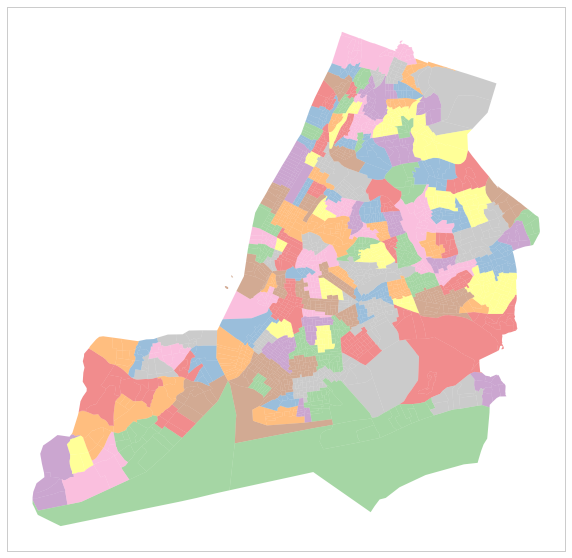

In [32]:
# plot the TADs
fig3, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
taz_nyc.plot(column='TADCE10', ax=ax, linewidth=0, cmap=cmap)
# plt.title("TITLE")

In [33]:
# dict matching TAD key with colors
color_dict = dict(zip(train_with_tad.TADCE10.unique(), colors))

In [34]:
# test_tad = ['00001001', '00002014']
# test_df = train_with_tad[train_with_tad['TADCE10'].isin(test_tad)]
# fig3 = plt.figure(figsize=(12, 12))
# plt.scatter(x=test_df.longitude.values, y=test_df.latitude.values, s=1, alpha=1, \
#             c=test_df['TADCE10'].map(color_dict))
# plt.xlim([-74.1,-73.7])
# plt.ylim([40.6, 40.9])
# plt.axis('off')

(-74.099999999999994,
 -73.700000000000003,
 40.600000000000001,
 40.899999999999999)

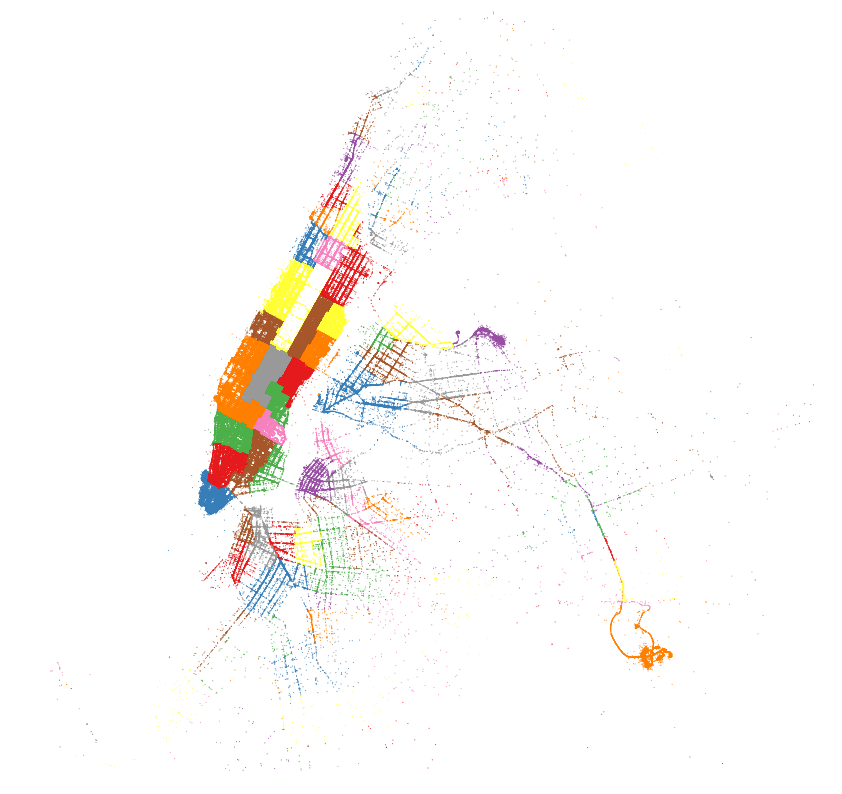

In [35]:
# plot pickup points colored by TAD, just to make sure the spatial join worked properly
fig4 = plt.figure(figsize=(14, 14))
plt.scatter(x=train_with_tad.longitude.values, y=train_with_tad.latitude.values, s=1, alpha=1, \
            lw=0, c=train_with_tad['TADCE10'].map(color_dict))
plt.xlim([-74.1,-73.7])
plt.ylim([40.6, 40.9])
plt.axis('off')